# Applications of Py-ART

In this section will use data sourced remoted from an archived kept in the [Amazon s3](https://aws.amazon.com/s3/) service produced by [Fugro ROAMES](https://www.roames.com/). This archive contains the entire Australian radar archive (over 850 years!) from present to 1997 (for some of the older radars). This archive is structured for easy integration with existing software like Py-ART, similar to the US [NEXRAD network on Amazon s3](https://aws.amazon.com/noaa-big-data/nexrad/). All data is stored using the odimh5 format.

This archive is structured by `radar_id / year / month / day / ID_yyyymmdd_HHMMSS.h5`. Radar ID consists of a two digit number for each site given by the BOM. For example, Melbourne radar is 02, Brisbane (Mt Stapylton) radar is 66. For this demonstration, only select parts of the archive are avaliable, while a full public release is pending.

Two application of Py-ART and the ROAMES s3 radar archive follow.

---

### How to use the Twitter API and Py-ART to Tweet Your Australian Radar!

Written by *Scott Collis, Argonne National Laboratory* Adapted for Australian radars by Joshua Soderholm

In [8]:
#Import required libraries

#twitter related
import twitter #https://python-twitter.readthedocs.io/en/latest/index.html
import json

#Radar related
import pyart
from mpl_toolkits.basemap import Basemap
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

#For web map service requests
from owslib.wms import WebMapService #https://geopython.github.io/OWSLib/

#For amazon s3 interactions
from boto.s3.connection import S3Connection #Anaconda installable

#Python libraries
import shutil, os, tempfile
from datetime import timedelta, datetime, date
import numpy as np

First, some functions to deal with Amazon Web Services Simple Storage Service (s3) holding of Australia radar data.

First, some functions to deal with Amazon Web Services Simple Storage Service (s3) holding of Australia radar data.

In [17]:
#This function takes an array of dates (dates) and finds the closest to the pivot date, allowing the closest matching
#file in s3 to be extracted.

def nearestDate(dates, pivot):
    """
    takes an array of dates (dates) and finds the closest to the pivot date, allowing the closest matching
    file in s3 to be extracted. Called by get_radar_from_aws.

    """
    return min(dates, key=lambda x: abs(x - pivot))


#This function takes a site id and a pivot datetime, extracts the closest file in the archive to the datetime,



def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime and returns a pyart radar object
    Parameters
    ----------
    site : string
        four letter radar designation 
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar object
    """
    
    #Connect to the s3 radar bucket containing data
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('roames-wxradar-archive')
    
    #Create the query string for the bucket knowing
    #how ROAMES stores their radar data in s3 (odimh5_archive/ID/yyyy/mm/dd/)
    my_pref = "odimh5_archive/" + site + datetime_t.strftime('/%Y/%m/%d')
    
    #Get a list of files using the query string
    bucket_list = list(bucket.list(prefix = my_pref))

    #we are going to create a list of keys (paths to files in s3 folder) and datetimes to allow easy searching
    keys = []
    datetimes = []
    
    #populate the list from bucket_list
    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        #only process files with the h5 extension (odimh5)
        if 'h5' in this_str:
            #strip out datetime from filename on s3 to create a list
            endme = this_str[-18:-3]
            fmt = '%Y%m%d_%H%M%S' 
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])
    
    #find the closest available radar to your datetime 
    closest_datetime = nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)
    
    #create a temp file, download radar data to file from S3
    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    
    #read into a pyart radar object and return
    radar = pyart.aux_io.read_odim_h5(localfile.name, file_field_names=True) 
    
    #add reflectivity description
    radar.fields['DBZH']['standard_name'] = 'Reflectivity'
    radar.fields['DBZH']['units'] = 'dBZ'
    radar.fields['DBZH']['long_name'] = 'Radar Reflectivity Factor'
    
    return radar

Now to setup the twitter api... Take a look [here](https://python-twitter.readthedocs.io/en/latest/getting_started.html)

This gives you instruction on how to populate the json file... 

Here is an example:
`
➜  twitterradar git:(tools_init) ✗ more token/PyWeather.json 
{"consumer_key":"SOMETHING",
"consumer_secret":"SOMETHINGELSE",
"access_token_key":"ANOTHERTHING",
"access_token_secret":"YETANOTHERTHING"}
`
---
Open my json file containing twitter credientials and pass to the twitter api

In [27]:
fh = open('/home/meso/aws_key/twitter_key.json')
myson = json.load(fh)
fh.close()

api = twitter.Api(consumer_key=myson['consumer_key'],
                  consumer_secret=myson['consumer_secret'],
                  access_token_key=myson['access_token_key'],
                  access_token_secret=myson['access_token_secret'])

Let's test the twitter api with a simple text update

In [28]:
status = api.PostUpdate("""Hello World, once again this is a test of tweeting using the Python API""")
print(status)

{"created_at": "Sat Nov 05 09:09:28 +0000 2016", "hashtags": [], "id": 794828970600505344, "id_str": "794828970600505344", "lang": "en", "source": "<a href=\"http://joshuasoderholm.com\" rel=\"nofollow\">wxradar twitter feed</a>", "text": "Hello World, once again this is a test of tweeting using the Python API", "urls": [], "user": {"created_at": "Fri Feb 26 06:24:03 +0000 2016", "description": "Severe weather meteorologist at the University of Queensland", "followers_count": 2, "friends_count": 4, "id": 703103210588753920, "lang": "en", "location": "Melbourne, Victoria", "name": "Joshua Soderholm", "profile_background_color": "000000", "profile_background_image_url": "http://abs.twimg.com/images/themes/theme1/bg.png", "profile_banner_url": "https://pbs.twimg.com/profile_banners/703103210588753920/1456468206", "profile_image_url": "http://pbs.twimg.com/profile_images/703105927851806720/YncEQyqu_normal.jpg", "profile_link_color": "ABB8C2", "profile_sidebar_fill_color": "000000", "profil

The is the primary function we call for generating a twitter image (it calls the other functions)

In [43]:
def tweet_my_radar(datetime, radar, tapi, min_lat = None,
                  max_lat = None, min_lon = None, 
                  max_lon = None, fig_sz = None):
    """
    Fetch a radar from S3, plot it and tweet plus statistics.
    
    Grab a radar from a site and use the Twitter API
    to tweet the PPI from the lowest tilt to twitter.
    Also tweet the number of gates above two reflectivity
    thresholds and the min and max reflectivity.
    
    Parameters
    ----------
    datetime: datetime object
        Python datetime object to be passed to the method
        to find the nearest radar object from AWS S3 using
        boto. 
    
    radar: String
        Two number radar code (e.g., 02 Sydney, 66 Brisbane)
    
    min_lat, max_lat, min_lon, max_lon: floats
        bounds for the display
        
    Returns
    -------
    None
    
    """
    #set figure size
    fig = plt.figure(figsize = fig_sz)
    
    #setup basemap
    ref_m = Basemap(llcrnrlon=min_lon,
                llcrnrlat=min_lat,
                urcrnrlon=max_lon,
                urcrnrlat=max_lat, 
                projection='tmerc', 
                resolution = 'h',
                epsg = 3857)
    
    #load background terrain image
    im = plt.imread('/tmp/background.png')
    ref_m.imshow(im,zorder = 0,origin='upper')
    
    #create radar object from nearest s3 file
    radar = get_radar_from_aws(radar,b_d )
    
    #Make a display
    display = pyart.graph.RadarMapDisplay(radar)
    
    #Plot reflectivity from second tilt
    display.plot_ppi_map('DBZH', sweep = 1, resolution = 'h',
                        vmin = -10, vmax = 64, mask_outside = True,
                        cmap = pyart.graph.cm.NWSRef,basemap = ref_m,zorder = 1)

    #overlay road and place image
    im = plt.imread('/tmp/overlay.png')
    ref_m.imshow(im,zorder = 2,origin='upper')
    
    #Save to tempfile.. Need png or Twitter gets grumpy 
    localfile = tempfile.NamedTemporaryFile()
    plt.savefig(localfile.name + '.png', dpi = 200)
    
    #Now generate some statistics.. 
    min_z = radar.fields['DBZH']['data'].min()
    max_z = radar.fields['DBZH']['data'].max()
    n_gates_20 = len(np.where(radar.fields['DBZH']['data'] > 20.0)[0])
    n_gates_40 = len(np.where(radar.fields['DBZH']['data'] > 40.0)[0])
    
    #Format the strings for twitter
    gdata = "There are {0} gates above 20dBZ and {1} above 40dBZ".format(n_gates_20, 
                                                                     n_gates_40)
    #Make the tweet text
    mmdata = "The min Z is {0}dBZ and the max is {1}dBZ".format(min_z,
                                                            max_z)
    #And... post it.. yes.. it is that easy!
    tapi.PostUpdate( gdata + ' ' + mmdata, 
              media = localfile.name + '.png')

This final function is used to generate a background image of terrin from [Open Street Maps](http://ows.terrestris.de) and an overlay image of roads/places from [Geoscience Australia](http://services.ga.gov.au/site_7/rest/services/Topographic_Base_Map_WM/MapServer)

In [30]:
def generate_layers(max_lat,min_lat,max_lon,min_lon):
    """
    Generates a background terrain image and an overlay places/roads image from wms sources
    
    Parameters
    ----------
    min_lat, max_lat, min_lon, max_lon: floats
        bounds for the display
        
    Returns
    -------
    None
    
    """    
    #generate map bounds
    lat_dif   = max_lat-min_lat
    lon_dif   = max_lon-min_lon
    map_x_sz  = int(500*lon_dif)
    map_y_sz  = int(500*lat_dif)

    #create overly map
    wms = WebMapService('http://services.ga.gov.au/site_7/services/Topographic_Base_Map_WM/MapServer/WMSServer?', version='1.1.1')
    img = wms.getmap(layers=['Roads_4','Populated_Places_6'],srs='EPSG:4326',bbox=(min_lon, min_lat, max_lon, max_lat),size=(map_x_sz, map_y_sz),format='image/png',transparent=True)
    out = open('/tmp/overlay.png', 'wb')
    out.write(img.read())
    out.close()  

    #create background map
    wms = WebMapService('http://ows.terrestris.de/osm-gray/service?', version='1.1.1')
    img = wms.getmap(layers=['TOPO-WMS'],srs='EPSG:4326',bbox=(min_lon, min_lat, max_lon, max_lat),size=(map_x_sz, map_y_sz),format='image/png',transparent=True)
    out = open('/tmp/background.png', 'wb')
    out.write(img.read())
    out.close() 

---

Ok! now we can string these functions together to generate some [twitter](https://twitter.com/jss_wx) posts!

---

In [45]:
#Let's post an image for the 17 October 2013 Blue Mountains Bushfire

#setup figure
pmax_lat  = -33.2134
pmin_lat  = -34.0646
pmin_lon  = 150.0719
pmax_lon  = 151.2443
fig_sz    = [7,8]
#set target time and radar_id
base_date = "20131017_051900"
radar     = "71"
#convert time to a time object
fmt       = '%Y%m%d_%H%M%S' 
b_d       = datetime.strptime(base_date, fmt)

#generate map layers
generate_layers(min_lat = pmin_lat, max_lat = pmax_lat,
                min_lon = pmin_lon, max_lon = pmax_lon)

#process img
tweet_my_radar(b_d, radar, api, min_lat = pmin_lat,
                  max_lat = pmax_lat, min_lon = pmin_lon, 
                  max_lon = pmax_lon, fig_sz = fig_sz)

In [ ]:
#Let's post an image for NOW in Brisbane

#setup figure
pmin_lat  = -28.6
pmax_lat  = -26.8
pmin_lon  = 152.7
pmax_lon  = 153.7 
fig_sz    = [7,8]
#set radar_id
radar     = "66"
#set base time to now
b_d     = datetime.now()


#generate map layers
generate_layers(min_lat = pmin_lat, max_lat = pmax_lat,
                min_lon = pmin_lon, max_lon = pmax_lon)

#generate twitter image!
tweet_my_radar(b_d, radar, api, min_lat = pmin_lat,
                  max_lat = pmax_lat, min_lon = pmin_lon, 
                  max_lon = pmax_lon, fig_sz = fig_sz)

## Py-ART Animation

This section generates an animation from multiple radar volumes extracted from amazon s3. The user is able to select the radar id and the animation start and stop time.

### Original notebook by Zach Sherman:
https://github.com/uq-crg/pyart_animation

### Based on code by Scott Collis:
https://github.com/scollis/radar_in_the_cloud/blob/master/notebooks/Matthew.ipynb 

### Jonathan Helmus:
https://anaconda.org/jjhelmus/scipy2015_openaccessradar_jjh/notebook

### and memory fixes by Robert Jackson:
https://github.com/rcjackson/pyart_practice/blob/master/nexrad_animatedgif.py

Note: AUS radar s3 files are set in UTC. 

In [38]:
#Import additional libraries for animation

import gzip
from matplotlib import animation
import pandas as pd
from IPython.display import Image, display

This function is for pulling all keys between two dates at a chosen radar site.

In [39]:
def ausrad_site_datespan(start_date=None, start_time=None, 
                         end_date=None, end_time=None, site=None):
    
    """
    Get all volumes from a radar id between two particular datetimes.
    Parameters
    ----------
    start_date : string
        eight number date, for example '20150623'
    start_date_time : string
        six number time, for example '145501'
    end_date : string
        eight number date or 'Now' to retrieve current UTC
    end_date_time : string, optional if end_date = 'Now'
        six number time
    site : string
        two digit radar designation number, for example '02' 
        
    """
    
    def datespan(startDate, endDate, delta=timedelta(days=1)):
        currentDate = startDate
        while currentDate < endDate:
            yield currentDate
            currentDate += delta

    #set user input time format
    fmt = '%Y/%m/%d_%H:%M:%S' 
    
    # Allows for the choice of now for the end date so current UTC is pulled.
    #process time input
    if end_date.upper() == 'NOW':
        e_d_selected = datetime.utcnow()
    else:
        e_d_selected = datetime.strptime(end_date + '_' + end_time, fmt)

    s_d = datetime.strptime(start_date + '_' + start_time, fmt)
    e_d = e_d_selected 
    if s_d > e_d_selected:
            raise ValueError('You provided a start date that comes after the end date.')
    times = []
    for timestamp in datespan((s_d), (e_d), delta=timedelta(days=1)):
        time = timestamp
        times += ["odimh5_archive/" + site + '/' + datetime.strftime(time, '%Y/%m/%d/')]

    #connect to s3 bucket    
    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('roames-wxradar-archive')
    
    #Get a list of files from s3
    keys = []
    datetimes = []
    for time in times:
        bucket_list = list(bucket.list(time))   
        for i in range(len(bucket_list)):
            this_str = str(bucket_list[i].key)
            if 'h5' in this_str:
                endme = this_str[-18:-3]
                fmt = '%Y%m%d_%H%M%S' 
                dt = datetime.strptime(endme, fmt)
                datetimes.append(dt)
                keys.append(bucket_list[i])

    # Code belows chooses all keys between the user's dates.
    d = {'keys': keys}
    key_object = pd.DataFrame(data=d, index=pd.to_datetime(datetimes))

    selected_keys = key_object.loc[s_d : e_d, :]
    #radar_datetimes = selected_keys.index.tolist()
    data_keys = selected_keys['keys'].tolist()
    return data_keys

In [40]:
# Conversion of s3 file keys to pyart radar objects.

def radar_keys_to_data(keys):
    #download data from s3
    localfile = tempfile.NamedTemporaryFile()
    keys.get_contents_to_filename(localfile.name)
    #generate radar object
    radar = pyart.aux_io.read_odim_h5(localfile.name, file_field_names=True)
    #correct field names
    radar.fields['DBZH']['standard_name'] = 'Reflectivity'
    radar.fields['DBZH']['units'] = 'dBZ'
    radar.fields['DBZH']['long_name'] = 'Radar Reflectivity Factor'
    return radar

In [41]:
# Creating a gif of all volumes between both dates.

def animate(nframe):
    
    #create basemap
    plt.clf()
    ref_m = Basemap(llcrnrlon=min_lon,
            llcrnrlat=min_lat,
            urcrnrlon=max_lon,
            urcrnrlat=max_lat, 
            projection='tmerc', 
            resolution = 'h',
            epsg = 3857)
    
    #load background image
    im = plt.imread('/tmp/background.png')
    ref_m.imshow(im,zorder = 0,origin='upper')
    #plot radar data
    radar = radar_keys_to_data(my_data_keys[nframe])
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi_map(field, sweep=sweep, resolution=bm_res,
                         vmin=vmin, vmax=vmax, mask_outside=False,
                         cmap=cmap,lat_lines=lal, lon_lines=lol,
                         basemap = ref_m, zorder = 1)
    #overlay mapping data
    im = plt.imread('/tmp/overlay.png')
    ref_m.imshow(im,zorder = 2,origin='upper')
    #overlay country outlines
    display.basemap.drawcounties()

Alright, now we can generate a gif from the s3 radar data archive

In [42]:
# Plotting and creating an animation using the radar datas.
# Something close to home.
# Use the option of saying 'now' to retrieve current UTC.

#set vars
radar_id     = '66'
field        = 'DBZH'
sweep        = 1
vmin         = 0
vmax         = 65
start_date   = '2008/11/16'
start_time   = '05:00:00'
end_date     = '2008/11/16'
end_time     = '07:00:00'
max_lat      = -27
min_lat      = -28.16
min_lon      = 152.2
max_lon      = 153.5
bm_res       = 'h' #l (low), i (intermediate), h (high), f (full)
cmap         = pyart.graph.cm.NWSRef

#create lat lon lines
lat_grid  = 0.2
lon_grid  = 0.2
lal       = np.arange(min_lat, max_lat, lat_grid)
lol       = np.arange(min_lon, max_lon, lon_grid)

# build s3 file keys
my_data_keys = ausrad_site_datespan(start_date=start_date,start_time=start_time,
                                         end_date=end_date,end_time=end_time,
                                         site=radar_id)
#confirm keys
print(my_data_keys)

#generate background and overlay images
generate_layers(min_lat = min_lat,max_lat = max_lat,
                min_lon = min_lon, max_lon = max_lon)

#generate images for animation
fig = plt.figure(figsize=(10, 8))
anim_66 = animation.FuncAnimation(fig, animate, frames=len(my_data_keys))

#save animation
anim_66.save('/home/meso/test.gif', writer='ImageMagick', fps=5)
plt.close()

[<Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_050034.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_050633.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_051233.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_051833.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_052433.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_053033.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_053633.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_054234.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_054833.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_055434.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_060035.h5>, <Key: roames-wxradar-archive,odimh5_archive/66/2008/11/16/66_20081116_060633.h5>, <Key: roames-wx

/home/meso/anaconda2/lib/python2.7/site-packages/matplotlib/animation.py:784: UserWarning: MovieWriter ImageMagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)
Exception TypeError: TypeError("'instancemethod' object is not connected",) in <bound method TimerQT.__del__ of <matplotlib.backends.backend_qt5.TimerQT object at 0x7fca504d4a90>> ignored
Traceback (most recent call last):
  File "/home/meso/anaconda2/lib/python2.7/site-packages/matplotlib/backends/backend_qt5agg.py", line 180, in __draw_idle_agg
    FigureCanvasAgg.draw(self)
  File "/home/meso/anaconda2/lib/python2.7/site-packages/matplotlib/backends/backend_agg.py", line 474, in draw
    self.figure.draw(self.renderer)
  File "/home/meso/anaconda2/lib/python2.7/site-packages/matplotlib/artist.py", line 62, in draw_wrapper
    draw(artist, renderer, *args, **kwargs)
  File "/home/meso/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py", line 1165, in draw
    self.canvas.draw_event(renderer)
  Fil

/home/meso/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/meso/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/home/meso/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/home/meso/anaconda2/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/home/meso/anaconda2/lib/python2.7/site-packages/IPython/core/form

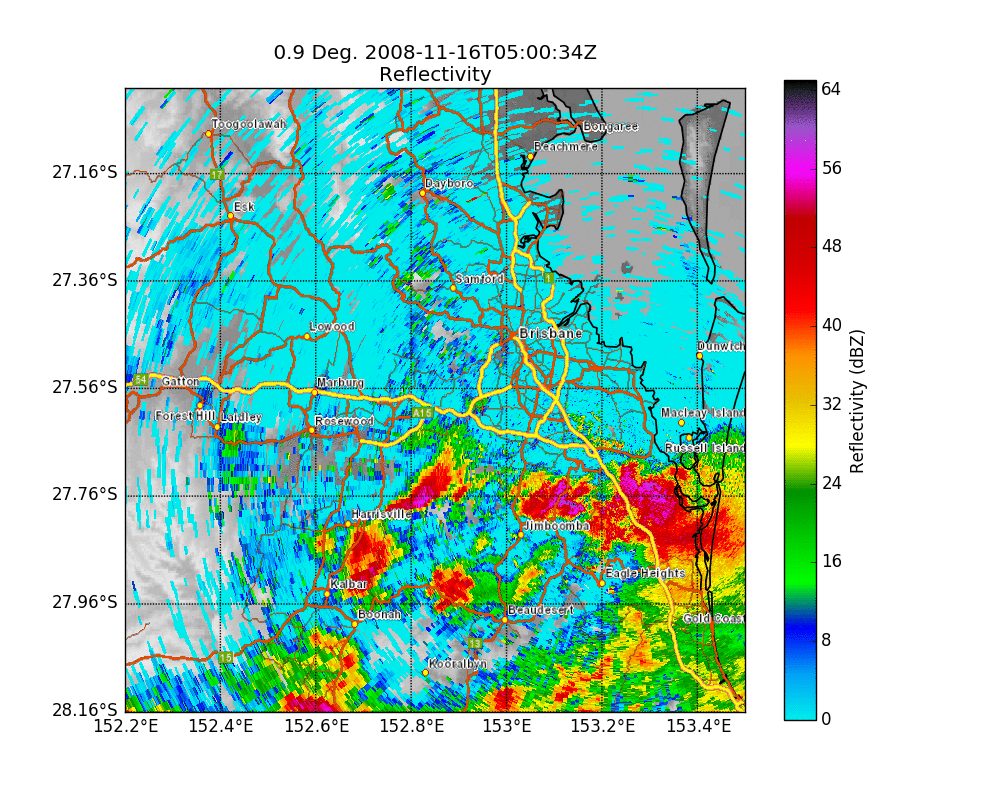

In [44]:
# Open gif in notebook
with open('/home/meso/test.gif','rb') as f:
    display(Image(f.read()), format='png')